In [1]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
import model_helper 
from helper import *
from scipy.stats import iqr

In [2]:
# Load wbc and treatment file 
wbc_df = pd.read_csv('CLL8 CLL cell count 10282024 UPDATED.csv')
treatment = pd.read_csv("GCLL_treatment.txt", sep = '\t')

# Get input files from Terra through dalmatian
patient = 'GCLL-0186'
workspace ='broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')

abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [3]:
# Select the wbc data for the patient

In [4]:
wbc_df_0186 = wbc_df[wbc_df['Patient'] == patient]
sample_list = wbc_df_0186['Timepoint'].dropna().tolist()

times_sample = [ int(i) for i in wbc_df_0186.loc[wbc_df_0186.Sample.notna(), 'Time_since_start_tx'].tolist()]
CLL_count = [float(i) for i in wbc_df_0186.loc[wbc_df_0186.Sample.notna(),'CLL count estm'].tolist()]

In [5]:
CLL_count

[105.78, 0.08370058, 0.37465575, 0.89662599, 2.52]

In [6]:
times_sample

[-3, 963, 1054, 1145, 1243]

In [7]:
# Select the UMI timepoints with index
UMI_start = 1
UMI_end = 4

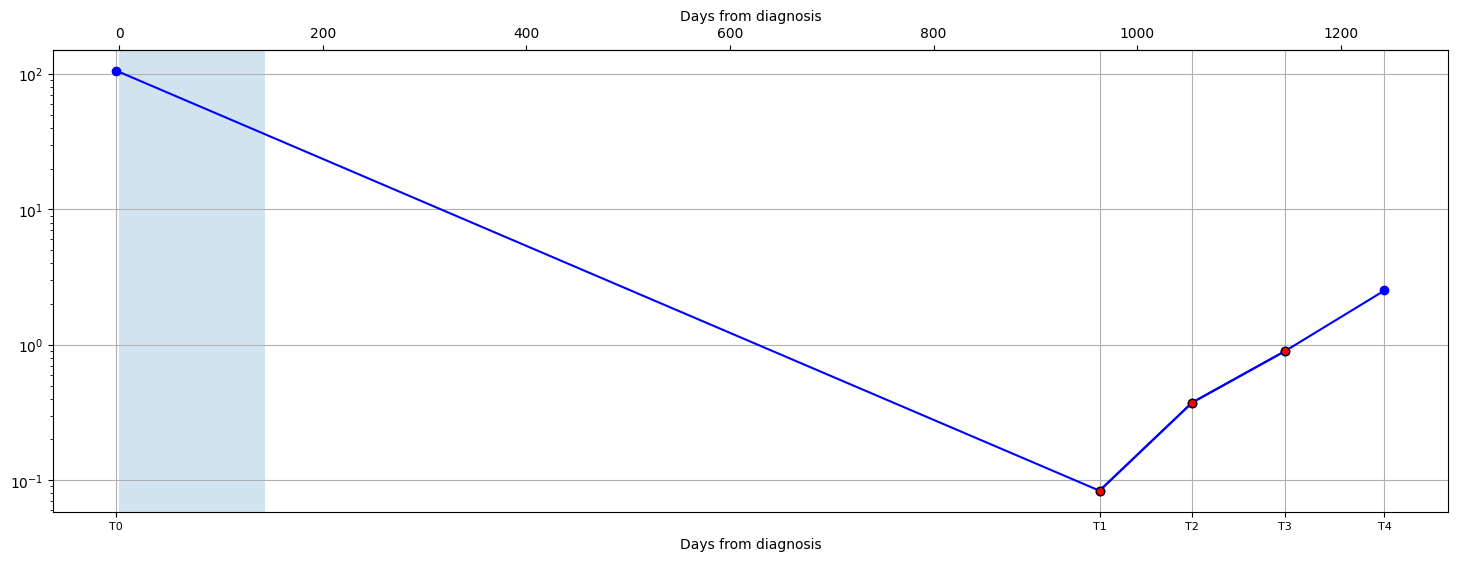

In [8]:
fig,ax = plt.subplots(1,1, figsize=(18,6))
ax.semilogy(times_sample,CLL_count,marker = 'o', color='blue')

# Create a scatter plot for the UMI timepoints with the red color
ax.semilogy(times_sample[UMI_start:UMI_end], CLL_count[UMI_start:UMI_end], color='blue',markerfacecolor='red',mec='black', marker = 'o')


# Fludarabine treatment 
ax.axvspan(xmin = 0, xmax= 143, label = "Fludarabine", alpha = 0.2)
ax.set_xlabel('Days from diagnosis')


number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]
ax.set_xticks(times_sample)
ax.set_xticklabels(tick_list, fontsize =8)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Days from diagnosis')
ax.grid(True)

Subclonal modeling

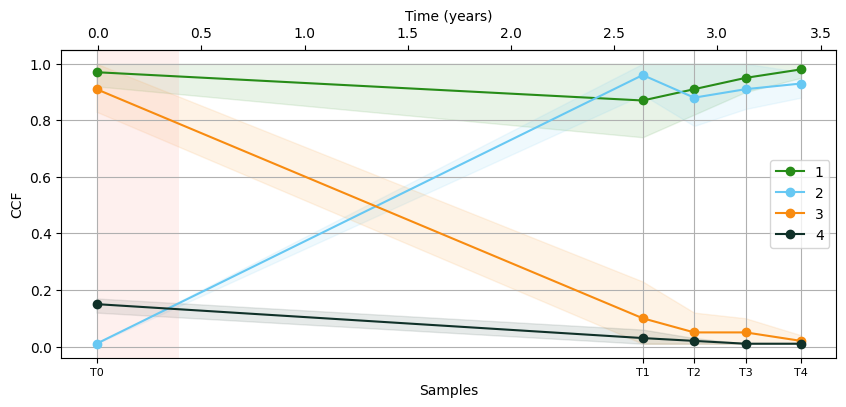

In [9]:
fig, ax = plt.subplots(figsize = (10, 4))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [10]:
abundance_df.Sample_ID.unique()

array(['GCLL-0186-T-02',
       'RP-1895_PDO-34670_SM-NPXT8_GCLL-0186-MRD-02_v1_Custom_Selection_OnPrem',
       'GCLL-0186-T-01',
       'RP-1895_PDO-34670_SM-NPXSE_GCLL-0186-MRD-03_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-34670_SM-NPXSY_GCLL-0186-MRD-01_v1_Custom_Selection_OnPrem'],
      dtype=object)

In [11]:
# Manually verify the sample list order is correct

In [12]:
sample_list = ['GCLL-0186-T-01','RP-1895_PDO-34670_SM-NPXSY_GCLL-0186-MRD-01_v1_Custom_Selection_OnPrem','RP-1895_PDO-34670_SM-NPXT8_GCLL-0186-MRD-02_v1_Custom_Selection_OnPrem',
               'RP-1895_PDO-34670_SM-NPXSE_GCLL-0186-MRD-03_v1_Custom_Selection_OnPrem',
 'GCLL-0186-T-02']

In [13]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [14]:
cluster_list

[1, 2, 3, 4]

In [15]:
cluster_abundance

{1: [0.0, 0.0, 0.0, 0.0, 0.07],
 2: [0.0, 0.87, 0.85, 0.94, 0.91],
 3: [0.83, 0.0, 0.0, 0.0, 0.01],
 4: [0.14, 0.0, 0.0, 0.0, 0.01]}

In [16]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count, cluster_abundance, cluster_list)


In [17]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [18]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [19]:
all_abundance

{1: {0: [0.0, 0.0, 0.03, 0.0, 0.06],
  1: [0.05, 0.0, 0.0, 0.0, 0.04],
  2: [0.06, 0.0, 0.0, 0.0, 0.02],
  3: [0.1, 0.0, 0.0, 0.0, 0.08],
  4: [0.03, 0.0, 0.0, 0.11, 0.06],
  5: [0.1, 0.0, 0.0, 0.0, 0.01],
  6: [0.09, 0.0, 0.01, 0.07, 0.07],
  7: [0.02, 0.0, 0.0, 0.0, 0.07],
  8: [0.0, 0.0, 0.03, 0.03, 0.0],
  9: [0.0, 0.0, 0.01, 0.05, 0.05],
  10: [0.0, 0.0, 0.0, 0.05, 0.0],
  11: [0.0, 0.0, 0.03, 0.0, 0.0],
  12: [0.05, 0.0, 0.0, 0.02, 0.01],
  13: [0.0, 0.0, 0.0, 0.02, 0.0],
  14: [0.0, 0.0, 0.0, 0.0, 0.03],
  15: [0.08, 0.0, 0.01, 0.03, 0.0],
  16: [0.0, 0.02, 0.0, 0.05, 0.05],
  17: [0.0, 0.0, 0.03, 0.0, 0.02],
  18: [0.0, 0.0, 0.01, 0.1, 0.03],
  19: [0.07, 0.0, 0.01, 0.13, 0.07],
  20: [0.1, 0.0, 0.0, 0.14, 0.05],
  21: [0.03, 0.0, 0.0, 0.09, 0.06],
  22: [0.15, 0.0, 0.0, 0.0, 0.01],
  23: [0.08, 0.0, 0.0, 0.0, 0.01],
  24: [0.0, 0.0, 0.0, 0.02, 0.04],
  25: [0.0, 0.0, 0.16, 0.07, 0.03],
  26: [0.0, 0.0, 0.0, 0.02, 0.07],
  27: [0.0, 0.0, 0.01, 0.0, 0.0],
  28: [0.02, 0.0, 0.09,

In [20]:
noise_added_original_all_abundances

{1: {0: [0.010453879178033358,
   0.01081827487208582,
   0.04504162830468057,
   0.003883986899817623,
   0.06668170489690536],
  1: [0.05287404835569319,
   0.009105852332662841,
   0.005111486258818868,
   0.009258906913443542,
   0.04174158475953754],
  2: [0.06639503924136546,
   0.00961041694069892,
   0.008126547014118964,
   0.008406136907239946,
   0.026761719387728974],
  3: [0.1034391489659613,
   0.010277702821151516,
   0.006684741088703307,
   0.0005360031580413321,
   0.08633086053084571],
  4: [0.032037988508562,
   0.005283552808139138,
   0.010540670006802878,
   0.11494189239767633,
   0.06551862358097325],
  5: [0.10998470020633994,
   0.005860881722529965,
   0.004730065477539692,
   0.003939106989542987,
   0.010741039788372472],
  6: [0.09532344607385711,
   0.002971755493712297,
   0.018700183760549292,
   0.08020249899032876,
   0.07926997738688049],
  7: [0.025850611151832095,
   0.008352797291855417,
   0.002994915767283708,
   0.0024689610566084423,
   0.070

In [21]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [22]:
wbc_df_0186

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample
78,7.0,GCLL-0186,11/21/05,11/24/05,11/21/05,-3,123.00,0.8600000000,0.0,105.78000000,GCLL-0186-T-01,CLL-GCLL-0186-Tumor-SM-41JZI
79,7.0,GCLL-0186,11/21/05,11/24/05,5/17/06,174,4.60,0.0000000000,1.0,0.00000000,NaN,NaN
80,7.0,GCLL-0186,11/21/05,11/24/05,7/11/06,229,4.60,0.0000000000,1.0,0.00000000,NaN,NaN
81,7.0,GCLL-0186,11/21/05,11/24/05,10/9/06,319,4.60,0.0000000000,1.0,0.00000000,NaN,NaN
82,7.0,GCLL-0186,11/21/05,11/24/05,1/15/07,417,4.60,0.0000539368,1.0,0.00000000,NaN,NaN
83,7.0,GCLL-0186,11/21/05,11/24/05,4/16/07,508,4.60,0.0001780624,0.0,0.00081909,NaN,NaN
84,7.0,GCLL-0186,11/21/05,11/24/05,7/16/07,599,4.60,0.0003319920,0.0,0.00152716,NaN,NaN
85,7.0,GCLL-0186,11/21/05,11/24/05,10/15/07,690,4.60,0.0012142398,0.0,0.00558550,NaN,NaN
86,7.0,GCLL-0186,11/21/05,11/24/05,7/14/08,963,4.60,0.0181957773,0.0,0.08370058,GCLL-0186-MRD-01,CLL-GCLL-0186-Tumor-SM-7C9BI
87,7.0,GCLL-0186,11/21/05,11/24/05,10/13/08,1054,5.10,0.0734619113,0.0,0.37465575,GCLL-0186-MRD-02,CLL-GCLL-0186-Tumor-SM-7C9BJ


In [23]:
times_sample

[-3, 963, 1054, 1145, 1243]

In [24]:
# Get the times at the start of the treatment and after 
all_times = [int(i) for i in wbc_df_0186['Time_since_start_tx'].to_list()]

times_aft_tx = [x for x in all_times if x > 143]
times_aft_tx.insert(0, 143)

In [25]:
# Get the times after treatment but before the first sample after treatment
times_for_wbc_est = [x for x in all_times if x > 143 and x <963]
times_for_wbc_est

[174, 229, 319, 417, 508, 599, 690]

In [26]:
times_aft_tx

[143, 174, 229, 319, 417, 508, 599, 690, 963, 1054, 1145, 1243]

In [27]:
# Linear Regression Modeling

In [28]:
CLL_count

[105.78, 0.08370058, 0.37465575, 0.89662599, 2.52]

In [29]:
# Set the extrapolate time after treatment
extrapolate_start_idx = 1
# extrapolate_end_idx = 6

extrapolate_times =times_sample[extrapolate_start_idx:]

In [30]:
extrapolate_times

[963, 1054, 1145, 1243]

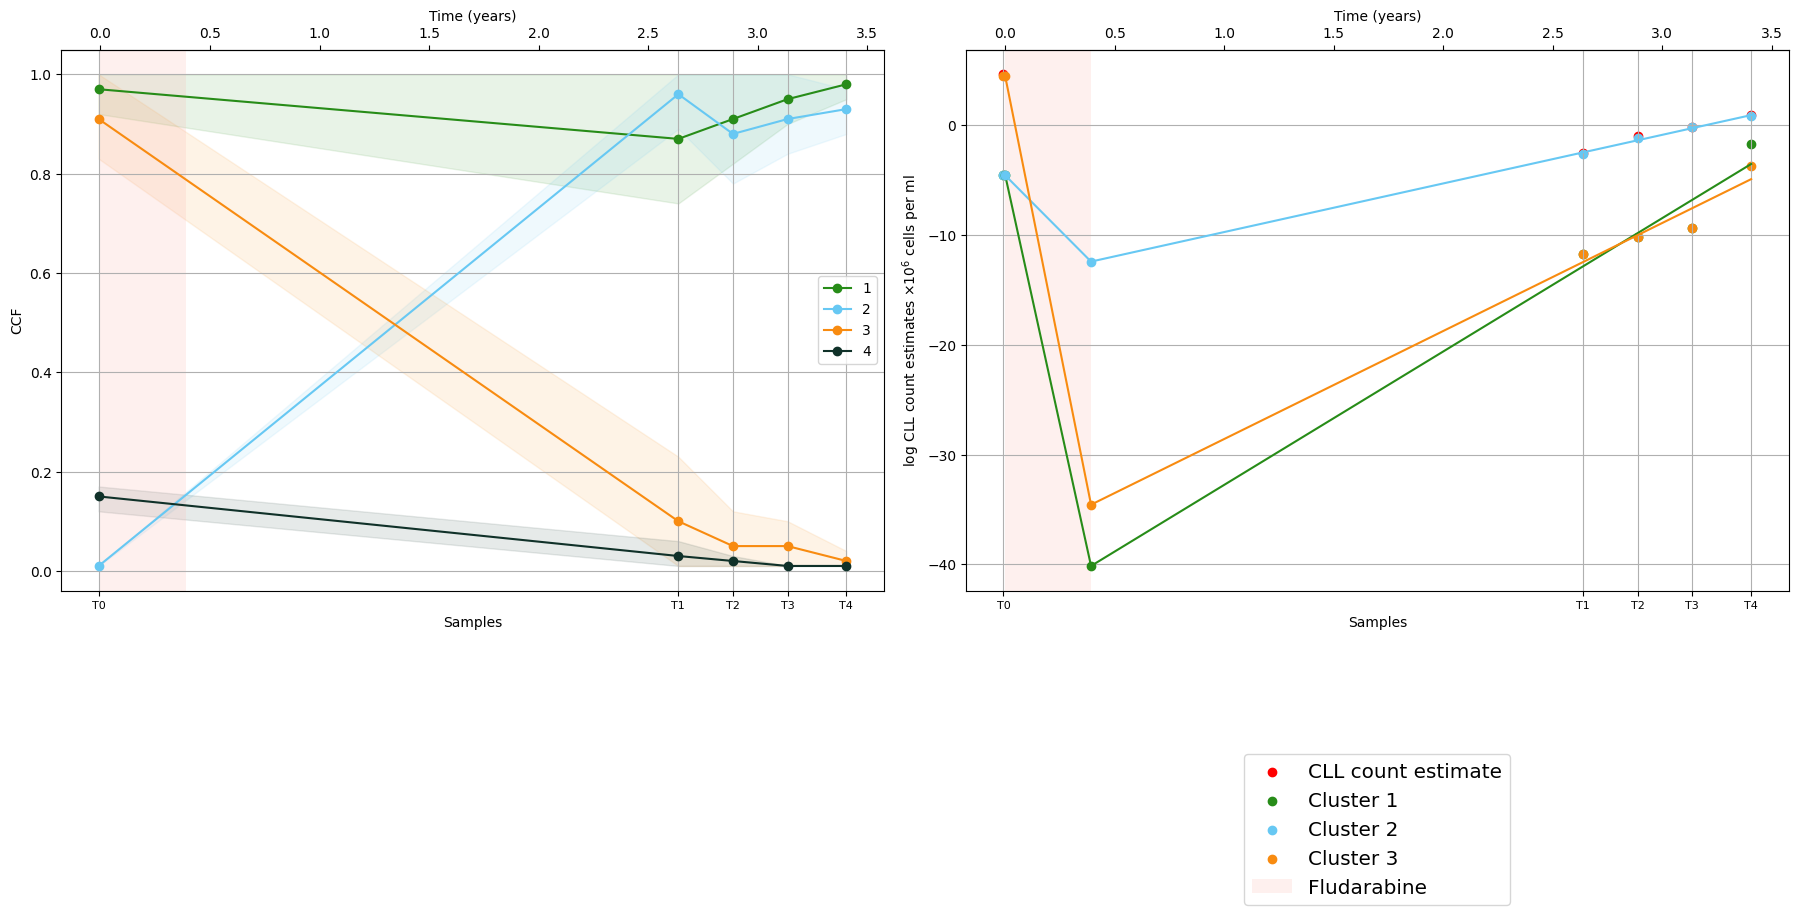

In [31]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, ])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, ]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [32]:
# Estimating total wbc after treatment using logsumexp

In [33]:
from scipy.special import logsumexp

[5.930867313644353e-06, 1.1565318717997132e-05, 3.44959039781083e-05, 0.00011338745585904576, 0.0003423327210972677, 0.001033551010872909, 0.0031204399486569217]


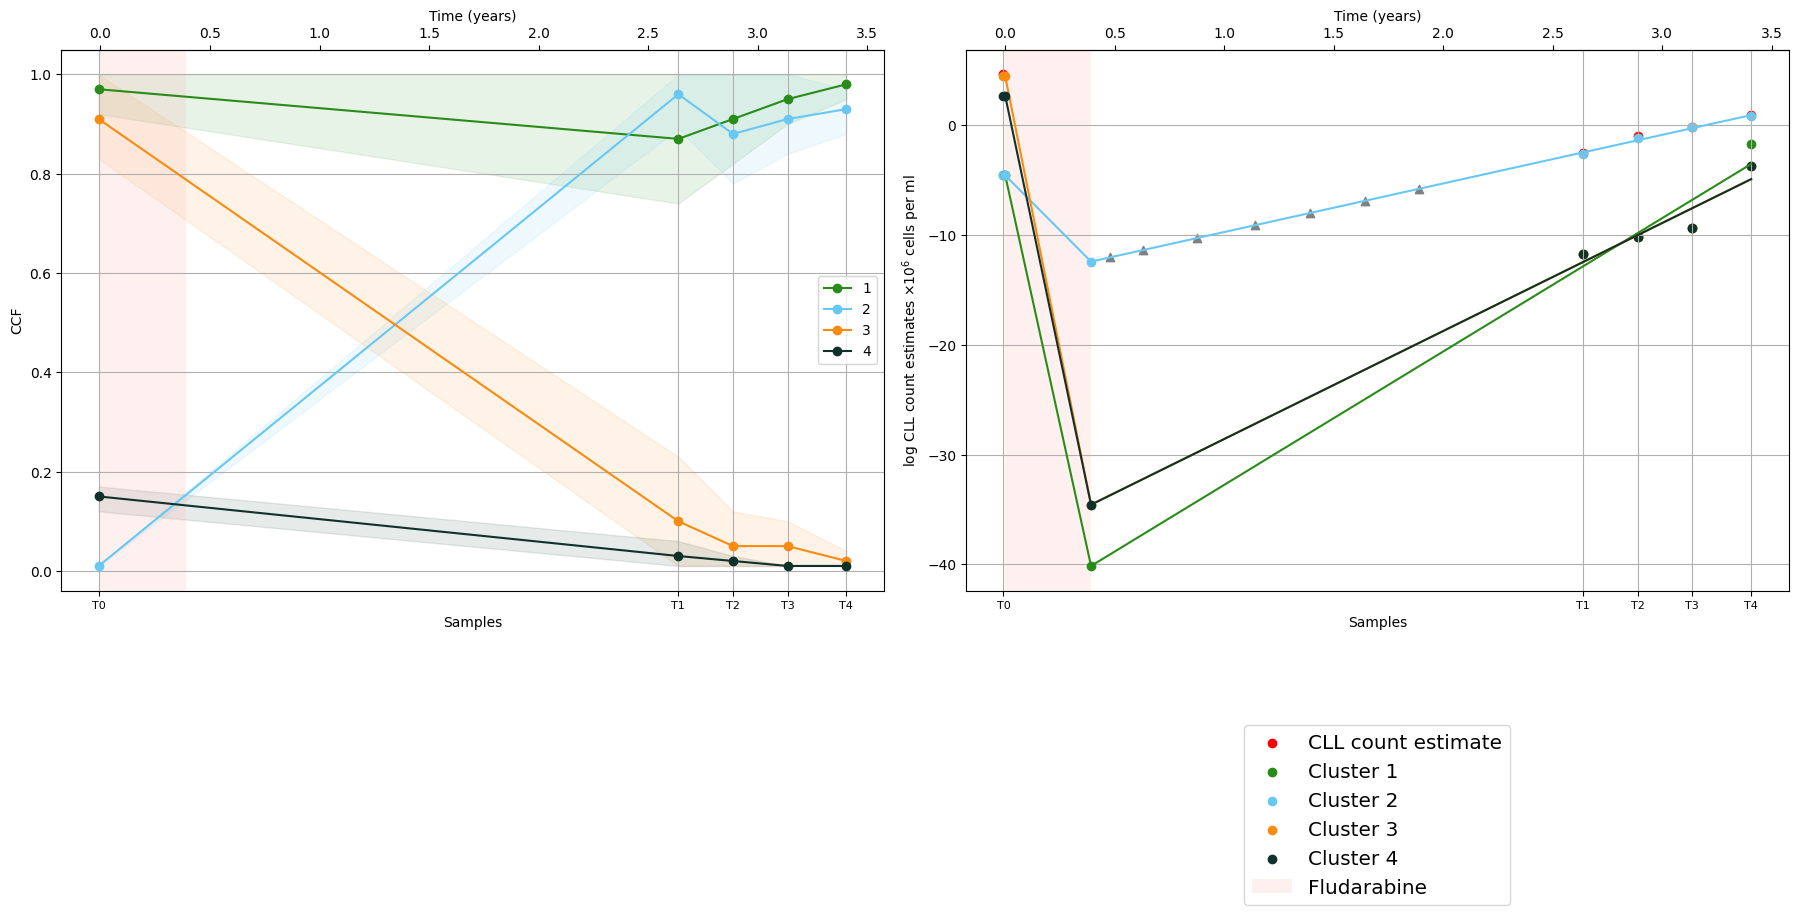

In [34]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        ## for wbc prediction after treatment
        times_for_wbc_est_year = [ i/365 for i in np.array(times_for_wbc_est)]
        cluster_cell_population[i] = np.polyval(model,times_for_wbc_est_year)
        
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

    ## Adding predicted wbc after treatment
   
    wbc_predicted =[]
    for timepoint in range(len(times_for_wbc_est)):
        predicted_all_subclone =[]
        for cluster in clusters:
            predicted_subclone = cluster_cell_population[cluster][timepoint]
            predicted_all_subclone.append(predicted_subclone)
        
        wbc_predicted.append(logsumexp(predicted_all_subclone))
        
    wbc_original = [ np.exp(i) for i in wbc_predicted]
    print(wbc_original)
    
    
    
    plt.scatter(times_for_wbc_est_year, wbc_predicted, color='grey',marker='^', alpha = 1)
    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    
    return wbc_original
    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




[5.930867313644353e-06, 1.1565318717997132e-05, 3.44959039781083e-05, 0.00011338745585904576, 0.0003423327210972677, 0.001033551010872909, 0.0031204399486569217]


,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap,Estimated_WBC_extrap
0,78,7.0,GCLL-0186,11/21/05,11/24/05,11/21/05,-3,123.00,0.860000,0.0,105.78000000,GCLL-0186-T-01,CLL-GCLL-0186-Tumor-SM-41JZI,NaN,NaN
1,79,7.0,GCLL-0186,11/21/05,11/24/05,5/17/06,174,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000006,inf
2,80,7.0,GCLL-0186,11/21/05,11/24/05,7/11/06,229,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000012,inf
3,81,7.0,GCLL-0186,11/21/05,11/24/05,10/9/06,319,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000034,inf
4,82,7.0,GCLL-0186,11/21/05,11/24/05,1/15/07,417,4.60,0.000054,1.0,0.00000000,NaN,NaN,0.000113,2.102228
5,83,7.0,GCLL-0186,11/21/05,11/24/05,4/16/07,508,4.60,0.000178,0.0,0.00081909,NaN,NaN,0.000342,1.922544
6,84,7.0,GCLL-0186,11/21/05,11/24/05,7/16/07,599,4.60,0.000332,0.0,0.00152716,NaN,NaN,0.001034,3.113180
7,85,7.0,GCLL-0186,11/21/05,11/24/05,10/15/07,690,4.60,0.001214,0.0,0.00558550,NaN,NaN,0.003120,2.569871
8,86,7.0,GCLL-0186,11/21/05,11/24/05,7/14/08,963,4.60,0.018196,0.0,0.08370058,GCLL-0186-MRD-01,CLL-GCLL-0186-Tumor-SM-7C9BI,NaN,NaN
9,87,7.0,GCLL-0186,11/21/05,11/24/05,10/13/08,1054,5.10,0.073462,0.0,0.37465575,GCLL-0186-MRD-02,CLL-GCLL-0186-Tumor-SM-7C9BJ,NaN,NaN


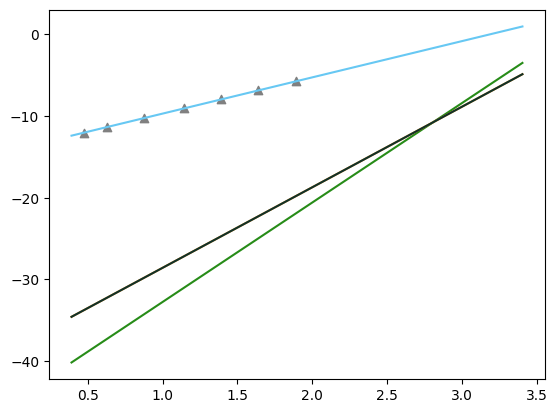

In [35]:
wbc_df_0186 = wbc_df[wbc_df['Patient'] == patient]

wbc_original = plot_sub(ax2, [1,2,3, 4])


wbc_df_0186 = wbc_df_0186.reset_index()

wbc_df_0186.loc[1:7, 'Estimated_CLL_extrap'] = wbc_original

wbc_df_0186['MRD'] = wbc_df_0186['MRD'].astype(float)
wbc_df_0186.loc[1:7, 'Estimated_WBC_extrap'] = wbc_df_0186['Estimated_CLL_extrap']/wbc_df_0186['MRD'] 

wbc_df_0186

In [36]:
# Adding iterations in the wbc estimation 

In [37]:


predicted_end_tx_clones = []

wbc_original_all_iterations = {}
def estimate_wbc(clusters):
    
        
    # plot total wbc
    
    for iter_idx in range(250):
    
        x_year = [ i/365 for i in np.array(times_sample)]
        

        # Extrapolate after treatment 
        cluster_cell_population = {}

        for i in clusters:
            x_year = [ i/365 for i in np.array(times_sample)]
            y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[i][iter_idx])

            # Extrapolate after treatment
            extrapolate_times =times_sample[extrapolate_start_idx:]
            extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
            extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[i][iter_idx][extrapolate_start_idx:]

            model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

            predict_x = times_aft_tx

            predict_year = [ i/365 for i in np.array(predict_x)]
            predicted = np.polyval(model, predict_year)

            ## for wbc prediction after treatment
            times_for_wbc_est_year = [ i/365 for i in np.array(times_for_wbc_est)]
            cluster_cell_population[i] = np.polyval(model,times_for_wbc_est_year)


            predicted_end_tx_clones.append(predicted[0])

    ## Adding predicted wbc after treatment
   
        wbc_predicted =[]
        for timepoint in range(len(times_for_wbc_est)):
            predicted_all_subclone =[]
            for cluster in clusters:
                predicted_subclone = cluster_cell_population[cluster][timepoint]
                predicted_all_subclone.append(predicted_subclone)

            wbc_predicted.append(logsumexp(predicted_all_subclone))

        wbc_original = [ np.exp(i) for i in wbc_predicted]
        wbc_original_all_iterations[iter_idx] = wbc_original

estimate_wbc([1,2,3, 4])


In [38]:
# Calculate the mean and confidence interval

num_elements = len(next(iter(wbc_original_all_iterations.values())))

# Initialize lists to store results
wbc_original_means = []
percentiles_2_5 = []
percentiles_97_5 = []

# Iterate over each position  in the lists
for i in range(num_elements):
    # Extract elements at the current position across all lists
    elements_at_position = [sublist[i] for sublist in wbc_original_all_iterations.values()]
    
    # Calculate the mean
    mean = np.mean(elements_at_position)
    wbc_original_means.append(mean)
    
    percentile_2_5 = np.percentile(elements_at_position, 2.5)
    percentile_97_5 = np.percentile(elements_at_position, 97.5)
    
    percentiles_2_5.append(percentile_2_5)
    percentiles_97_5.append(percentile_97_5)

[5.930867313644353e-06, 1.1565318717997132e-05, 3.44959039781083e-05, 0.00011338745585904576, 0.0003423327210972677, 0.001033551010872909, 0.0031204399486569217]


,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap,Estimated_CLL_extrap_mean,Estimated_CLL_extrap_2_5,Estimated_CLL_extrap_97_5,Estimated_WBC_extrap_mean,Estimated_WBC_extrap_2_5,Estimated_WBC_extrap_97_5
0,78,7.0,GCLL-0186,11/21/05,11/24/05,11/21/05,-3,123.00,0.860000,0.0,105.78000000,GCLL-0186-T-01,CLL-GCLL-0186-Tumor-SM-41JZI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79,7.0,GCLL-0186,11/21/05,11/24/05,5/17/06,174,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000006,0.294532,0.000008,0.090065,inf,inf,inf
2,80,7.0,GCLL-0186,11/21/05,11/24/05,7/11/06,229,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000012,0.172023,0.000015,0.073775,inf,inf,inf
3,81,7.0,GCLL-0186,11/21/05,11/24/05,10/9/06,319,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000034,0.072500,0.000044,0.053502,inf,inf,inf
4,82,7.0,GCLL-0186,11/21/05,11/24/05,1/15/07,417,4.60,0.000054,1.0,0.00000000,NaN,NaN,0.000113,0.029459,0.000139,0.041195,546.171182,2.573610,763.765537
5,83,7.0,GCLL-0186,11/21/05,11/24/05,4/16/07,508,4.60,0.000178,0.0,0.00081909,NaN,NaN,0.000342,0.013881,0.000410,0.033331,77.953138,2.301484,187.186114
6,84,7.0,GCLL-0186,11/21/05,11/24/05,7/16/07,599,4.60,0.000332,0.0,0.00152716,NaN,NaN,0.001034,0.008103,0.001198,0.026477,24.407833,3.608335,79.751767
7,85,7.0,GCLL-0186,11/21/05,11/24/05,10/15/07,690,4.60,0.001214,0.0,0.00558550,NaN,NaN,0.003120,0.007787,0.003521,0.024355,6.412782,2.900012,20.057947
8,86,7.0,GCLL-0186,11/21/05,11/24/05,7/14/08,963,4.60,0.018196,0.0,0.08370058,GCLL-0186-MRD-01,CLL-GCLL-0186-Tumor-SM-7C9BI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87,7.0,GCLL-0186,11/21/05,11/24/05,10/13/08,1054,5.10,0.073462,0.0,0.37465575,GCLL-0186-MRD-02,CLL-GCLL-0186-Tumor-SM-7C9BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


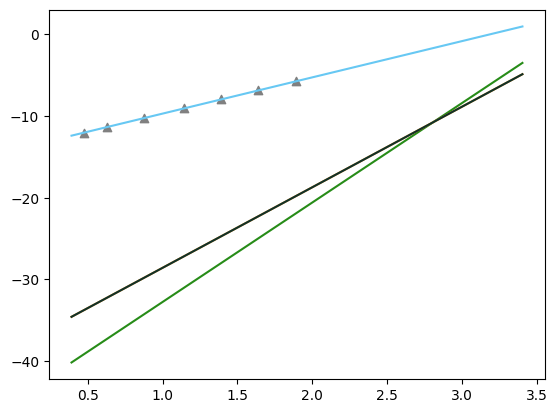

In [39]:
wbc_df_0186 = wbc_df[wbc_df['Patient'] == patient]

wbc_original = plot_sub(ax2, [1,2,3, 4])

wbc_df_0186 = wbc_df_0186.reset_index()

wbc_df_0186.loc[1:7, 'Estimated_CLL_extrap'] = wbc_original

wbc_df_0186.loc[1:7, 'Estimated_CLL_extrap_mean'] = wbc_original_means
wbc_df_0186.loc[1:7, 'Estimated_CLL_extrap_2_5'] = percentiles_2_5
wbc_df_0186.loc[1:7, 'Estimated_CLL_extrap_97_5'] = percentiles_97_5


wbc_df_0186['MRD'] = wbc_df_0186['MRD'].astype(float)
wbc_df_0186.loc[1:7, 'Estimated_WBC_extrap_mean'] = wbc_df_0186['Estimated_CLL_extrap_mean']/wbc_df_0186['MRD'] 
wbc_df_0186.loc[1:7, 'Estimated_WBC_extrap_2_5'] = wbc_df_0186['Estimated_CLL_extrap_2_5']/wbc_df_0186['MRD'] 
wbc_df_0186.loc[1:7, 'Estimated_WBC_extrap_97_5'] = wbc_df_0186['Estimated_CLL_extrap_97_5']/wbc_df_0186['MRD'] 

wbc_df_0186

In [40]:
# Adding all the iterations

In [41]:
subclone_sample_mcmc_with_uniform_noise[1][0]

[1.1163893394523685,
 0.0009138659393930088,
 0.01691257060871133,
 0.0035721461981960074,
 0.16828989634020153]

In [42]:
CLL_count

[105.78, 0.08370058, 0.37465575, 0.89662599, 2.52]

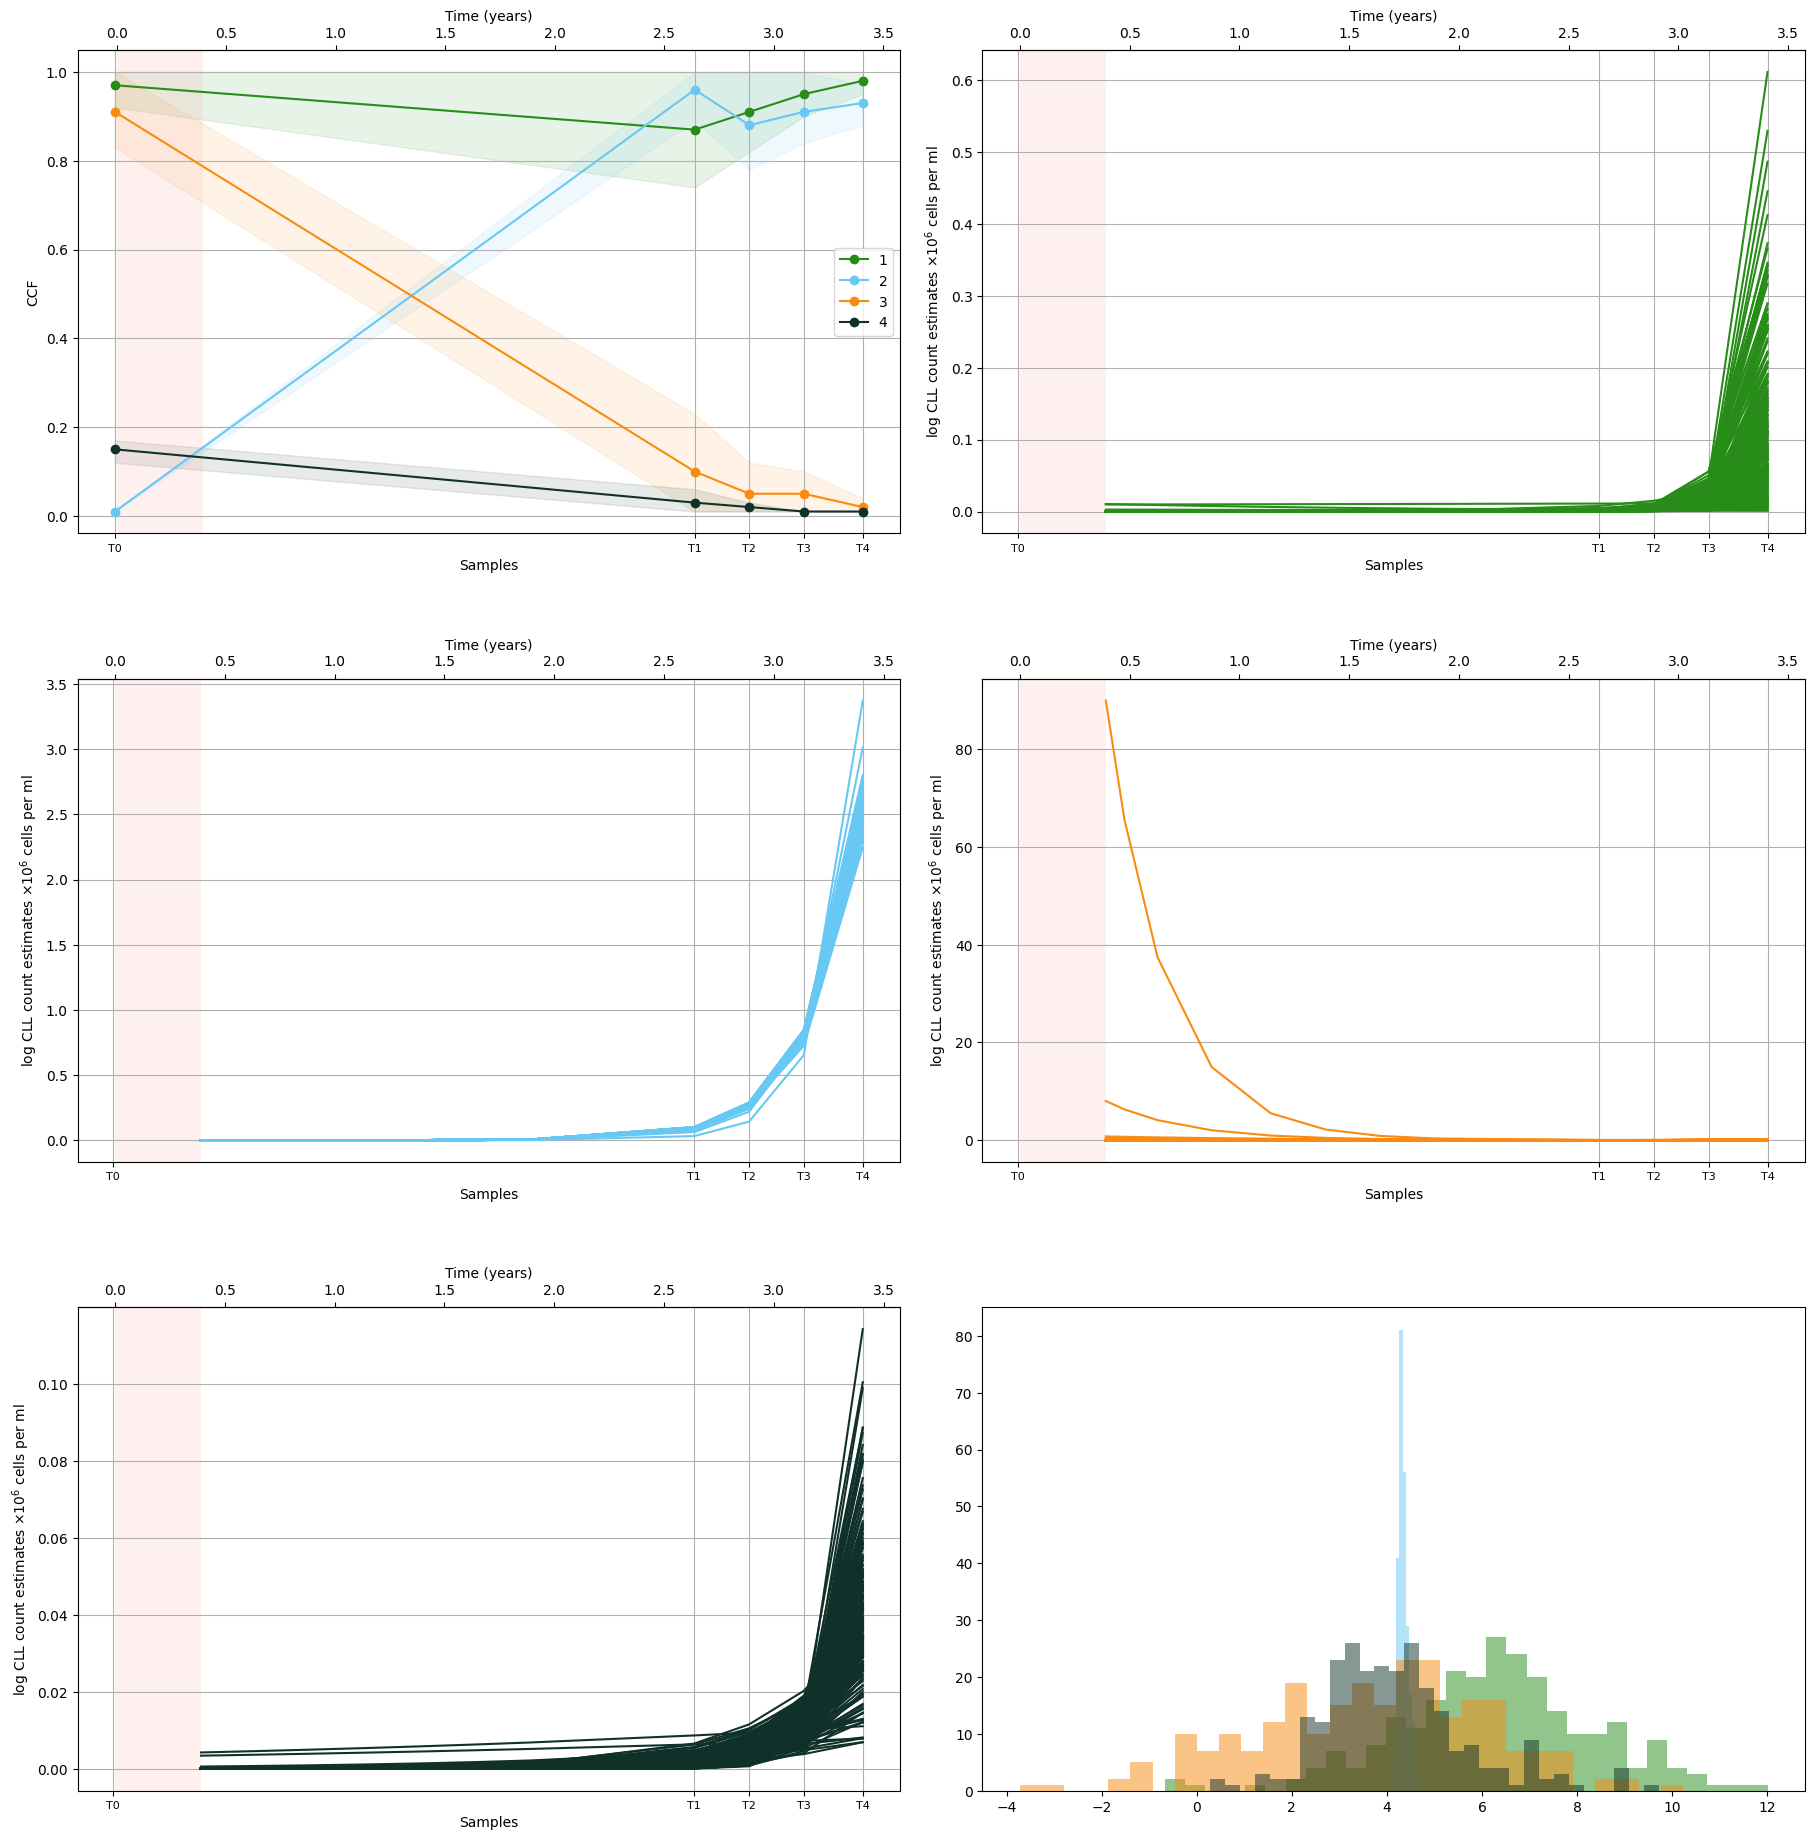

In [43]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




slopes_mcmc = {}
def plot_sub_mcmc(ax, cluster):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
#     ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    
    slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])
#         ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][extrapolate_start_idx:]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        
        slopes_mcmc[cluster].append(model[0])
        

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
#         ax.plot(predict_year, predicted, color=ClusterColors.get_hex_string(cluster))
        predicted_normal = [np.exp(i) for i in predicted]
        ax.plot(predict_year, predicted_normal, color=ClusterColors.get_hex_string(cluster))


        times_during_tx = [0,143/365]

       

        tx_start_clones = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][0]

        
#         ax.plot(times_during_tx, [tx_start_clones, predicted[0]], color=ClusterColors.get_hex_string(cluster), marker = 'o')

        
    


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub_mcmc(ax2, 1)
plot_sub_mcmc(ax3, 2)
plot_sub_mcmc(ax4, 3)
plot_sub_mcmc(ax5, 4)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in clusters:
    ax6.hist(slopes_mcmc[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster), bins = 30)


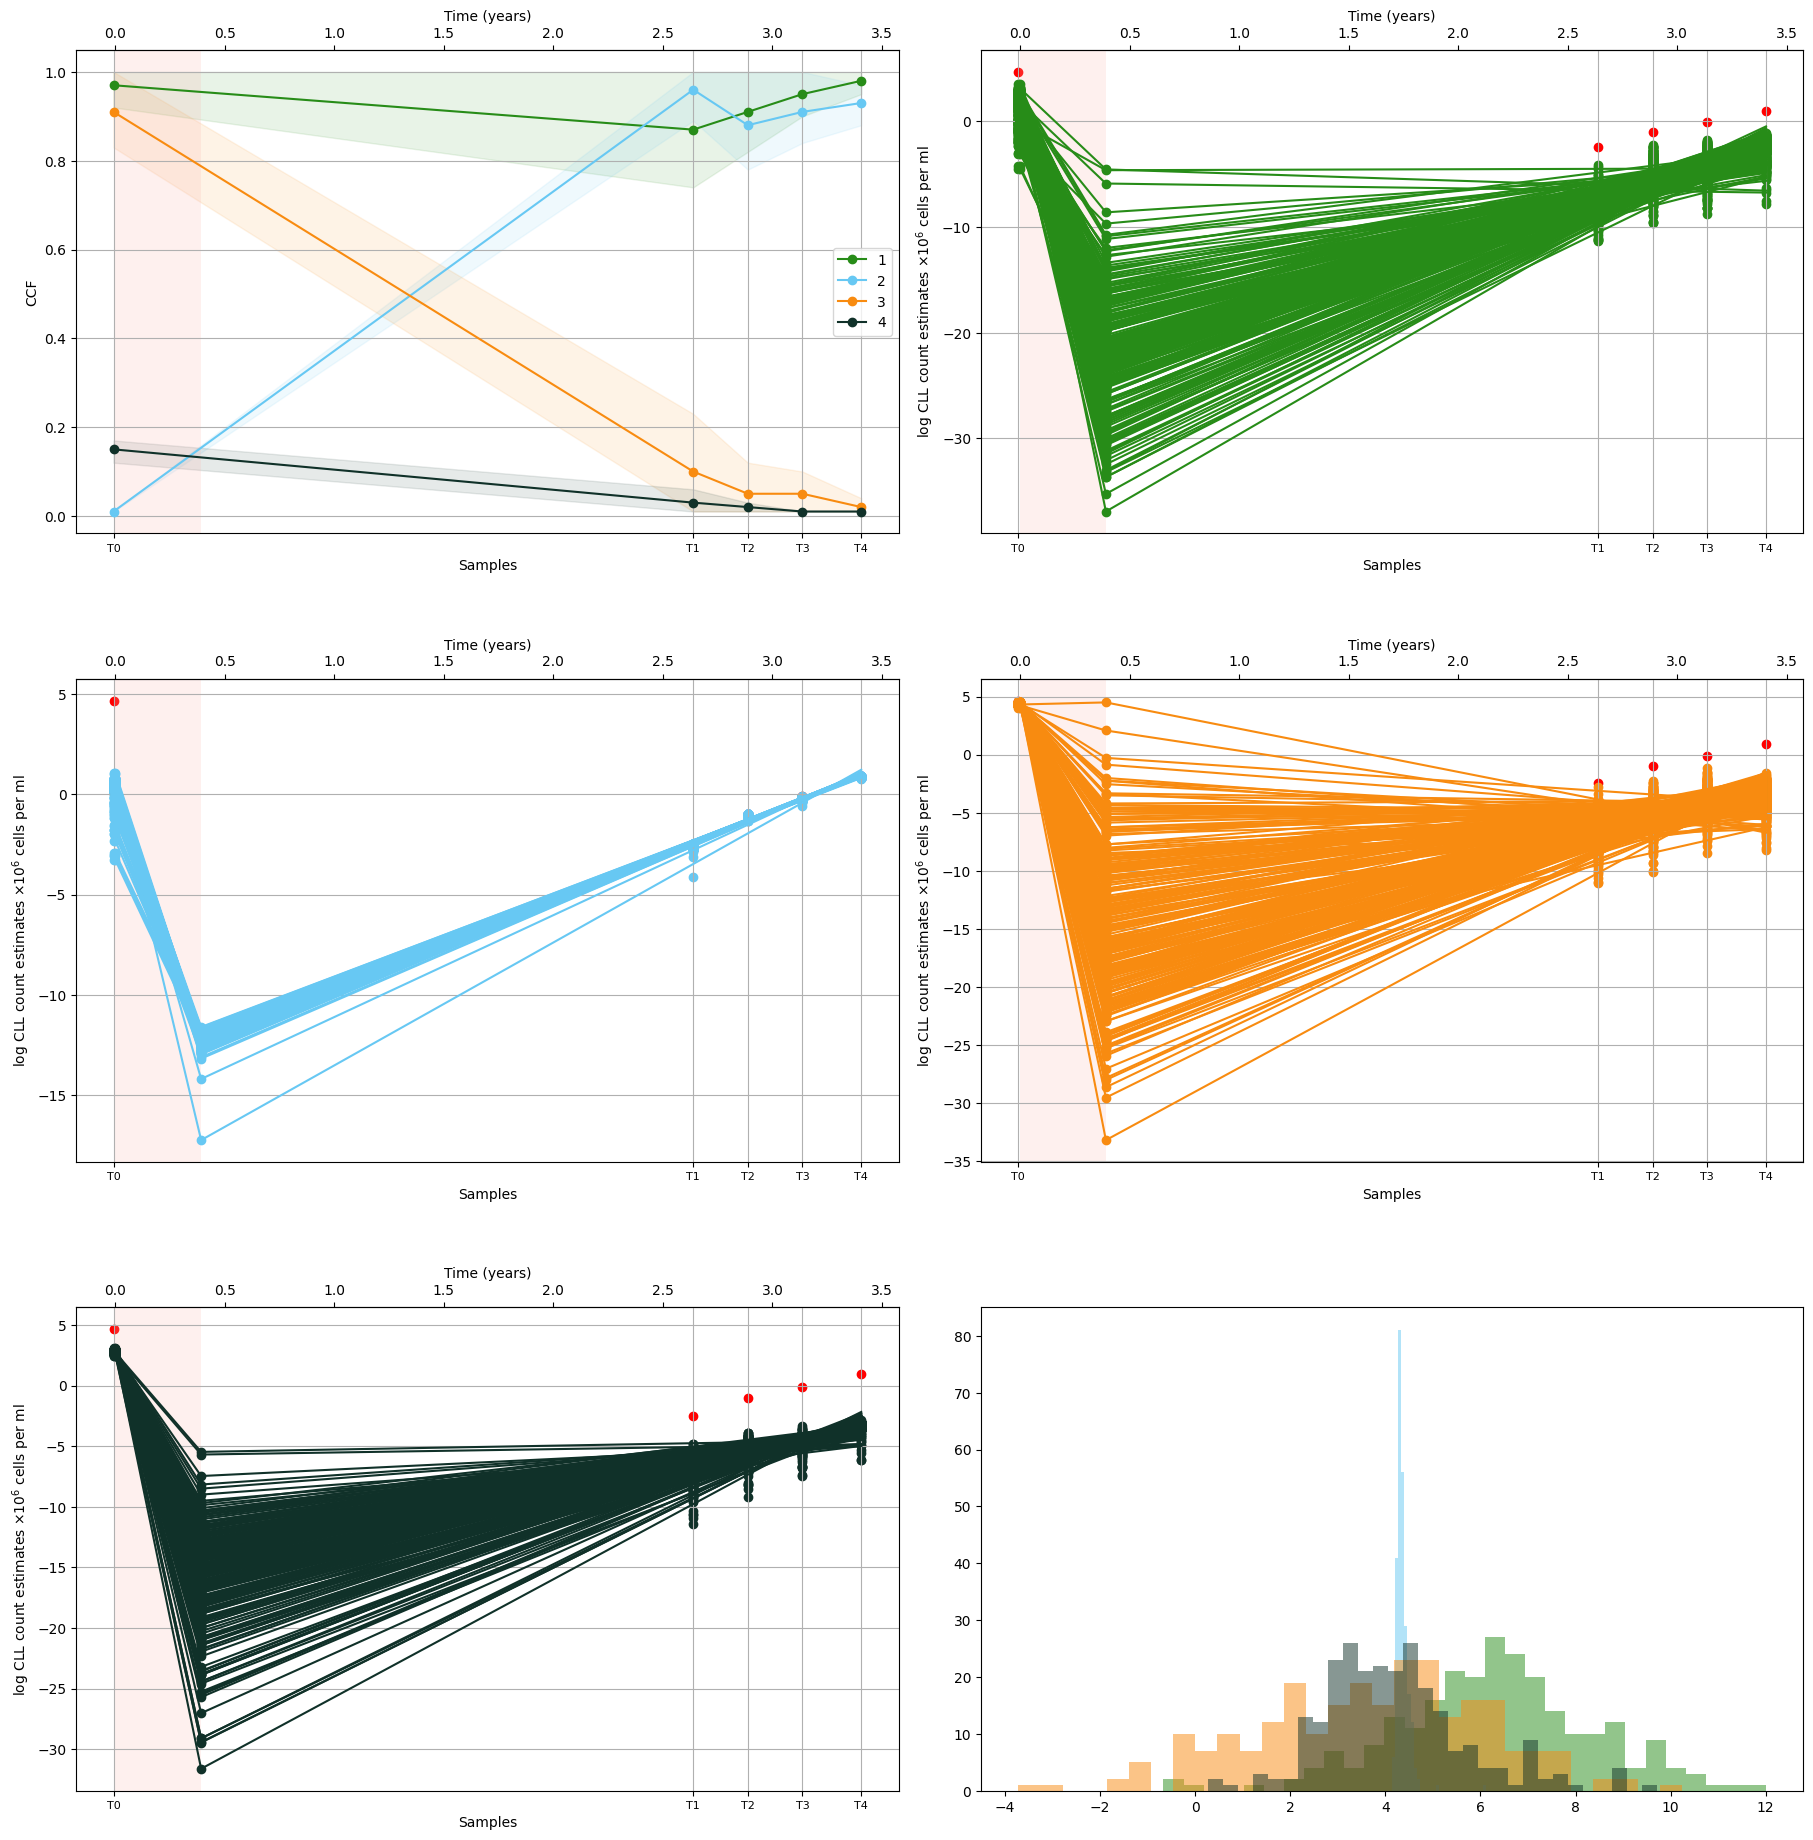

In [44]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




slopes_mcmc = {}
def plot_sub_mcmc(ax, cluster):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    
    slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][extrapolate_start_idx:]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        
        slopes_mcmc[cluster].append(model[0])
        

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        ax.plot(predict_year, predicted, color=ClusterColors.get_hex_string(cluster))


        times_during_tx = [0,143/365]

       

        tx_start_clones = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][0]

        
        ax.plot(times_during_tx, [tx_start_clones, predicted[0]], color=ClusterColors.get_hex_string(cluster), marker = 'o')

        
    


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub_mcmc(ax2, 1)
plot_sub_mcmc(ax3, 2)
plot_sub_mcmc(ax4, 3)
plot_sub_mcmc(ax5, 4)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in clusters:
    ax6.hist(slopes_mcmc[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster), bins = 30)


In [45]:
for cluster in clusters:
    mean = np.mean(slopes_mcmc[cluster], axis=0)
    lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")
    
    

Cluster: 1, mean:6.3193, 95% Confidence Interval: 2.3279 to 10.1143
Cluster: 2, mean:4.3586, 95% Confidence Interval: 4.2008 to 4.6106
Cluster: 3, mean:3.7303, 95% Confidence Interval: -1.0441 to 7.8475
Cluster: 4, mean:4.2000, 95% Confidence Interval: 1.6071 to 7.6815


In [46]:
# Adopt the CRC model 

from scipy.special import logsumexp 
from scipy.optimize import minimize

class MultiClusterLinearRegression:
    def __init__(self, n_clusters,X, y):
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y
        
        
    def calculate_weight_ratio(self ):
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        
        weight_ratio = num_wbc / ((num_exomes)*(self.n_clusters -1))
        return weight_ratio
        

    def objective(self, params, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        weight_ratio = self.calculate_weight_ratio()
        
        # calculate predicted y values for all clusters 
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
   
            if yi is not None:
                likelihood +=  weight_ratio * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i]))**2

        return likelihood  # We minimize negative log-likelihood



    def fit(self, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 




        
        
    def calculate_likelihood(self, params, logsumexp_points):
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts
        
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i])**2)
                print(f"exome logsubclone: {yi},exome predicted: {y_pred[i]}, likelihood_y: {likelihood_y}")
        
       
        print(f"squared sum_y: {likelihood_y}")
        
        
        likelihood_logsumexp = 0 
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i]))**2
                print(f"log wbc: {lse},wbc predicted: {logsumexp(y_pred[i])}")
        print(f"squared sum_logsumexp: {likelihood_logsumexp}")
        
        total_squared_sum = likelihood_y + likelihood_logsumexp
    
        print(f"total squared sum: {total_squared_sum}")
        return likelihood_y, likelihood_logsumexp
    


    def predict(self,):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts
    



In [47]:
def create_inputs(times_sliced, log_subclone_sample_mcmc,iter, index_samples_model):
    
    X = [ i/365 for i in np.array(times_sliced)]
    
    
    # reconstruct the dictionary so that {iteration number: cluster number :[time]}
    log_subclone_cluster_iter = {}
    
    # Iterate through each cluster
    for cluster, iterations in log_subclone_sample_mcmc.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            # Add the cluster and its value to this iteration
            log_subclone_cluster_iter[iteration][cluster] = value
    
    
    
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values)
    array_trans = array.T
    selected_sample = array_trans[index_samples_model]
    
    
    times_sample_selected = times_sample[index_samples_model]
    indices = [i for i, x in enumerate(times_sliced) if x in times_sample_selected]
    
    y = [None] * len(times_sliced)
    i = 0
    # Fill the rows that correspond with the exome points
    for index in indices: 
        y[index] = selected_sample[i]
        i +=1
    
    
    return X, y
    

In [48]:
wbc_df_0186

,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap,Estimated_CLL_extrap_mean,Estimated_CLL_extrap_2_5,Estimated_CLL_extrap_97_5,Estimated_WBC_extrap_mean,Estimated_WBC_extrap_2_5,Estimated_WBC_extrap_97_5
0,78,7.0,GCLL-0186,11/21/05,11/24/05,11/21/05,-3,123.00,0.860000,0.0,105.78000000,GCLL-0186-T-01,CLL-GCLL-0186-Tumor-SM-41JZI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79,7.0,GCLL-0186,11/21/05,11/24/05,5/17/06,174,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000006,0.294532,0.000008,0.090065,inf,inf,inf
2,80,7.0,GCLL-0186,11/21/05,11/24/05,7/11/06,229,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000012,0.172023,0.000015,0.073775,inf,inf,inf
3,81,7.0,GCLL-0186,11/21/05,11/24/05,10/9/06,319,4.60,0.000000,1.0,0.00000000,NaN,NaN,0.000034,0.072500,0.000044,0.053502,inf,inf,inf
4,82,7.0,GCLL-0186,11/21/05,11/24/05,1/15/07,417,4.60,0.000054,1.0,0.00000000,NaN,NaN,0.000113,0.029459,0.000139,0.041195,546.171182,2.573610,763.765537
5,83,7.0,GCLL-0186,11/21/05,11/24/05,4/16/07,508,4.60,0.000178,0.0,0.00081909,NaN,NaN,0.000342,0.013881,0.000410,0.033331,77.953138,2.301484,187.186114
6,84,7.0,GCLL-0186,11/21/05,11/24/05,7/16/07,599,4.60,0.000332,0.0,0.00152716,NaN,NaN,0.001034,0.008103,0.001198,0.026477,24.407833,3.608335,79.751767
7,85,7.0,GCLL-0186,11/21/05,11/24/05,10/15/07,690,4.60,0.001214,0.0,0.00558550,NaN,NaN,0.003120,0.007787,0.003521,0.024355,6.412782,2.900012,20.057947
8,86,7.0,GCLL-0186,11/21/05,11/24/05,7/14/08,963,4.60,0.018196,0.0,0.08370058,GCLL-0186-MRD-01,CLL-GCLL-0186-Tumor-SM-7C9BI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87,7.0,GCLL-0186,11/21/05,11/24/05,10/13/08,1054,5.10,0.073462,0.0,0.37465575,GCLL-0186-MRD-02,CLL-GCLL-0186-Tumor-SM-7C9BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Convert the column "CLL count estm" to float 
wbc_df_0186['CLL count estm'] = wbc_df_0186['CLL count estm'].astype(float) 

In [50]:
 
times_sliced_aft = [int(i) for i in wbc_df_0186[wbc_df_0186['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

In [51]:
times_sliced_aft

[508, 599, 690, 963, 1054, 1145, 1243]

In [52]:
wbc_guess= np.linspace(3, 4.6, 4)

In [53]:
wbc_guess

array([3.        , 3.53333333, 4.06666667, 4.6       ])

In [54]:
CLL_guess = [0.00053419,
0.00117193,
0.00494196,
0.08370058,
0.37465575,
0.89662599,
2.52000000]

In [55]:
len(CLL_guess)

7

In [56]:
# 
n_clusters = 4

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,2, slice(1,5))

logsumexp_points = np.log(CLL_guess)

In [57]:
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [61]:
logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]


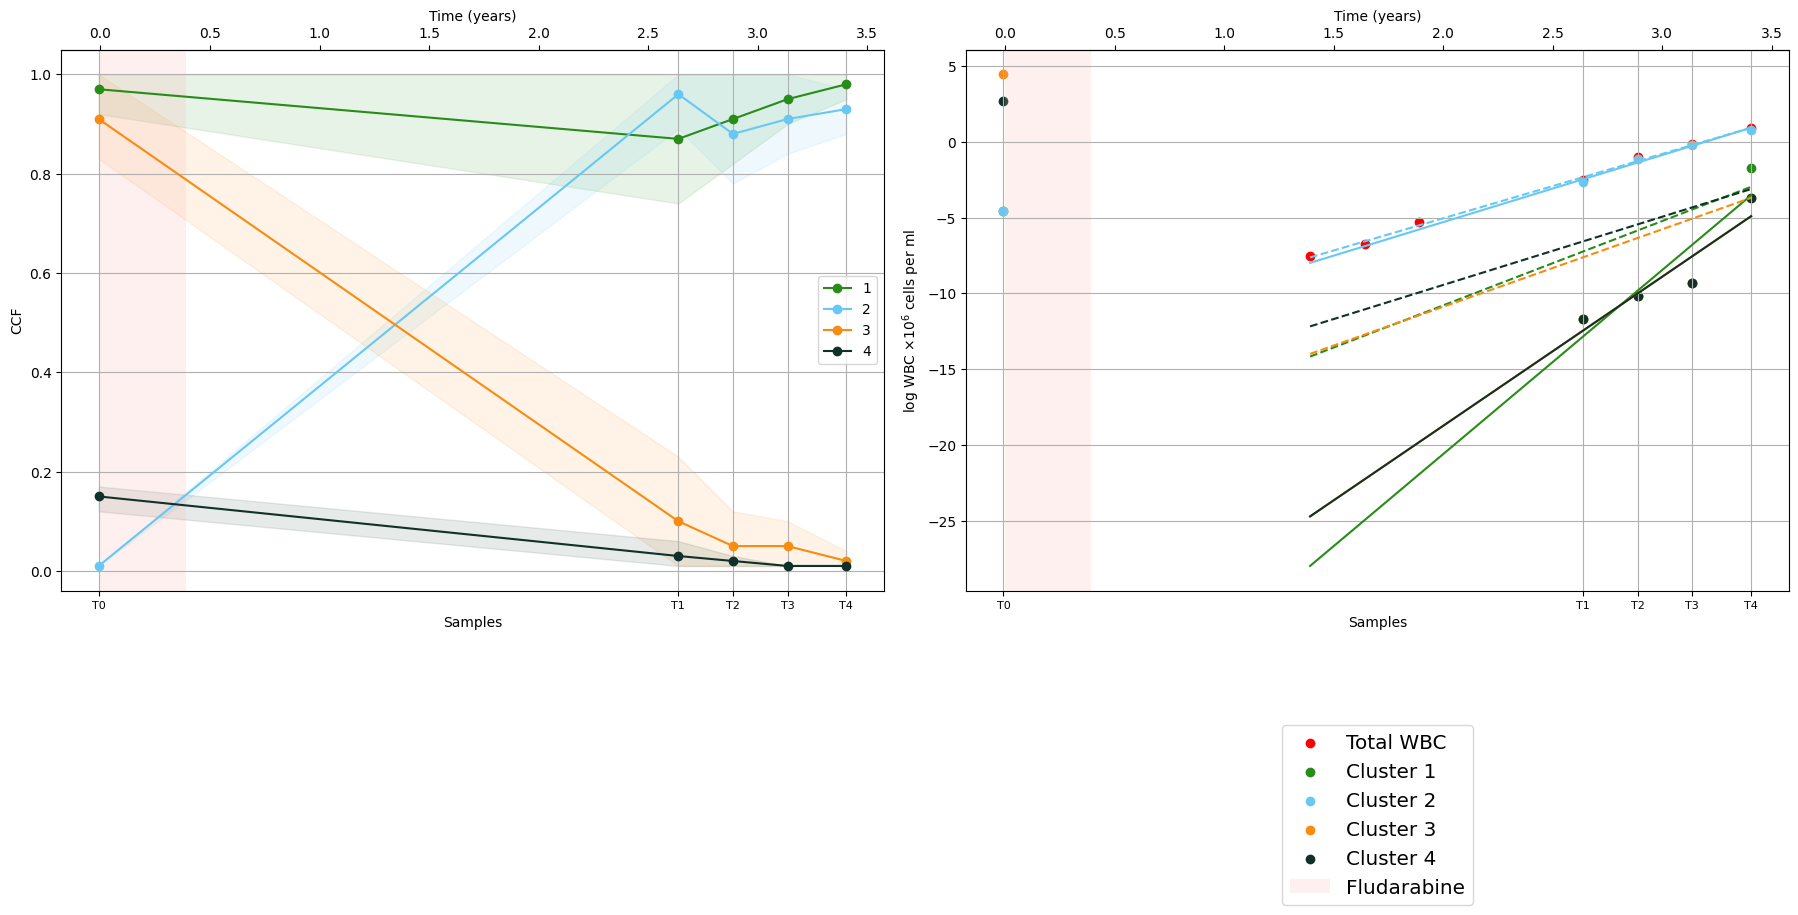

In [62]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, extrapolate_start_idx,model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        
  
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        

        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')
    
    
    
    

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

extrapolate_start_idx =1
plot_model_single_iter(ax2, [1,2,3, 4], extrapolate_start_idx,model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4]:

    ax2.plot(X,model.predict()[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(X, logsumexp_points_model,marker='^')

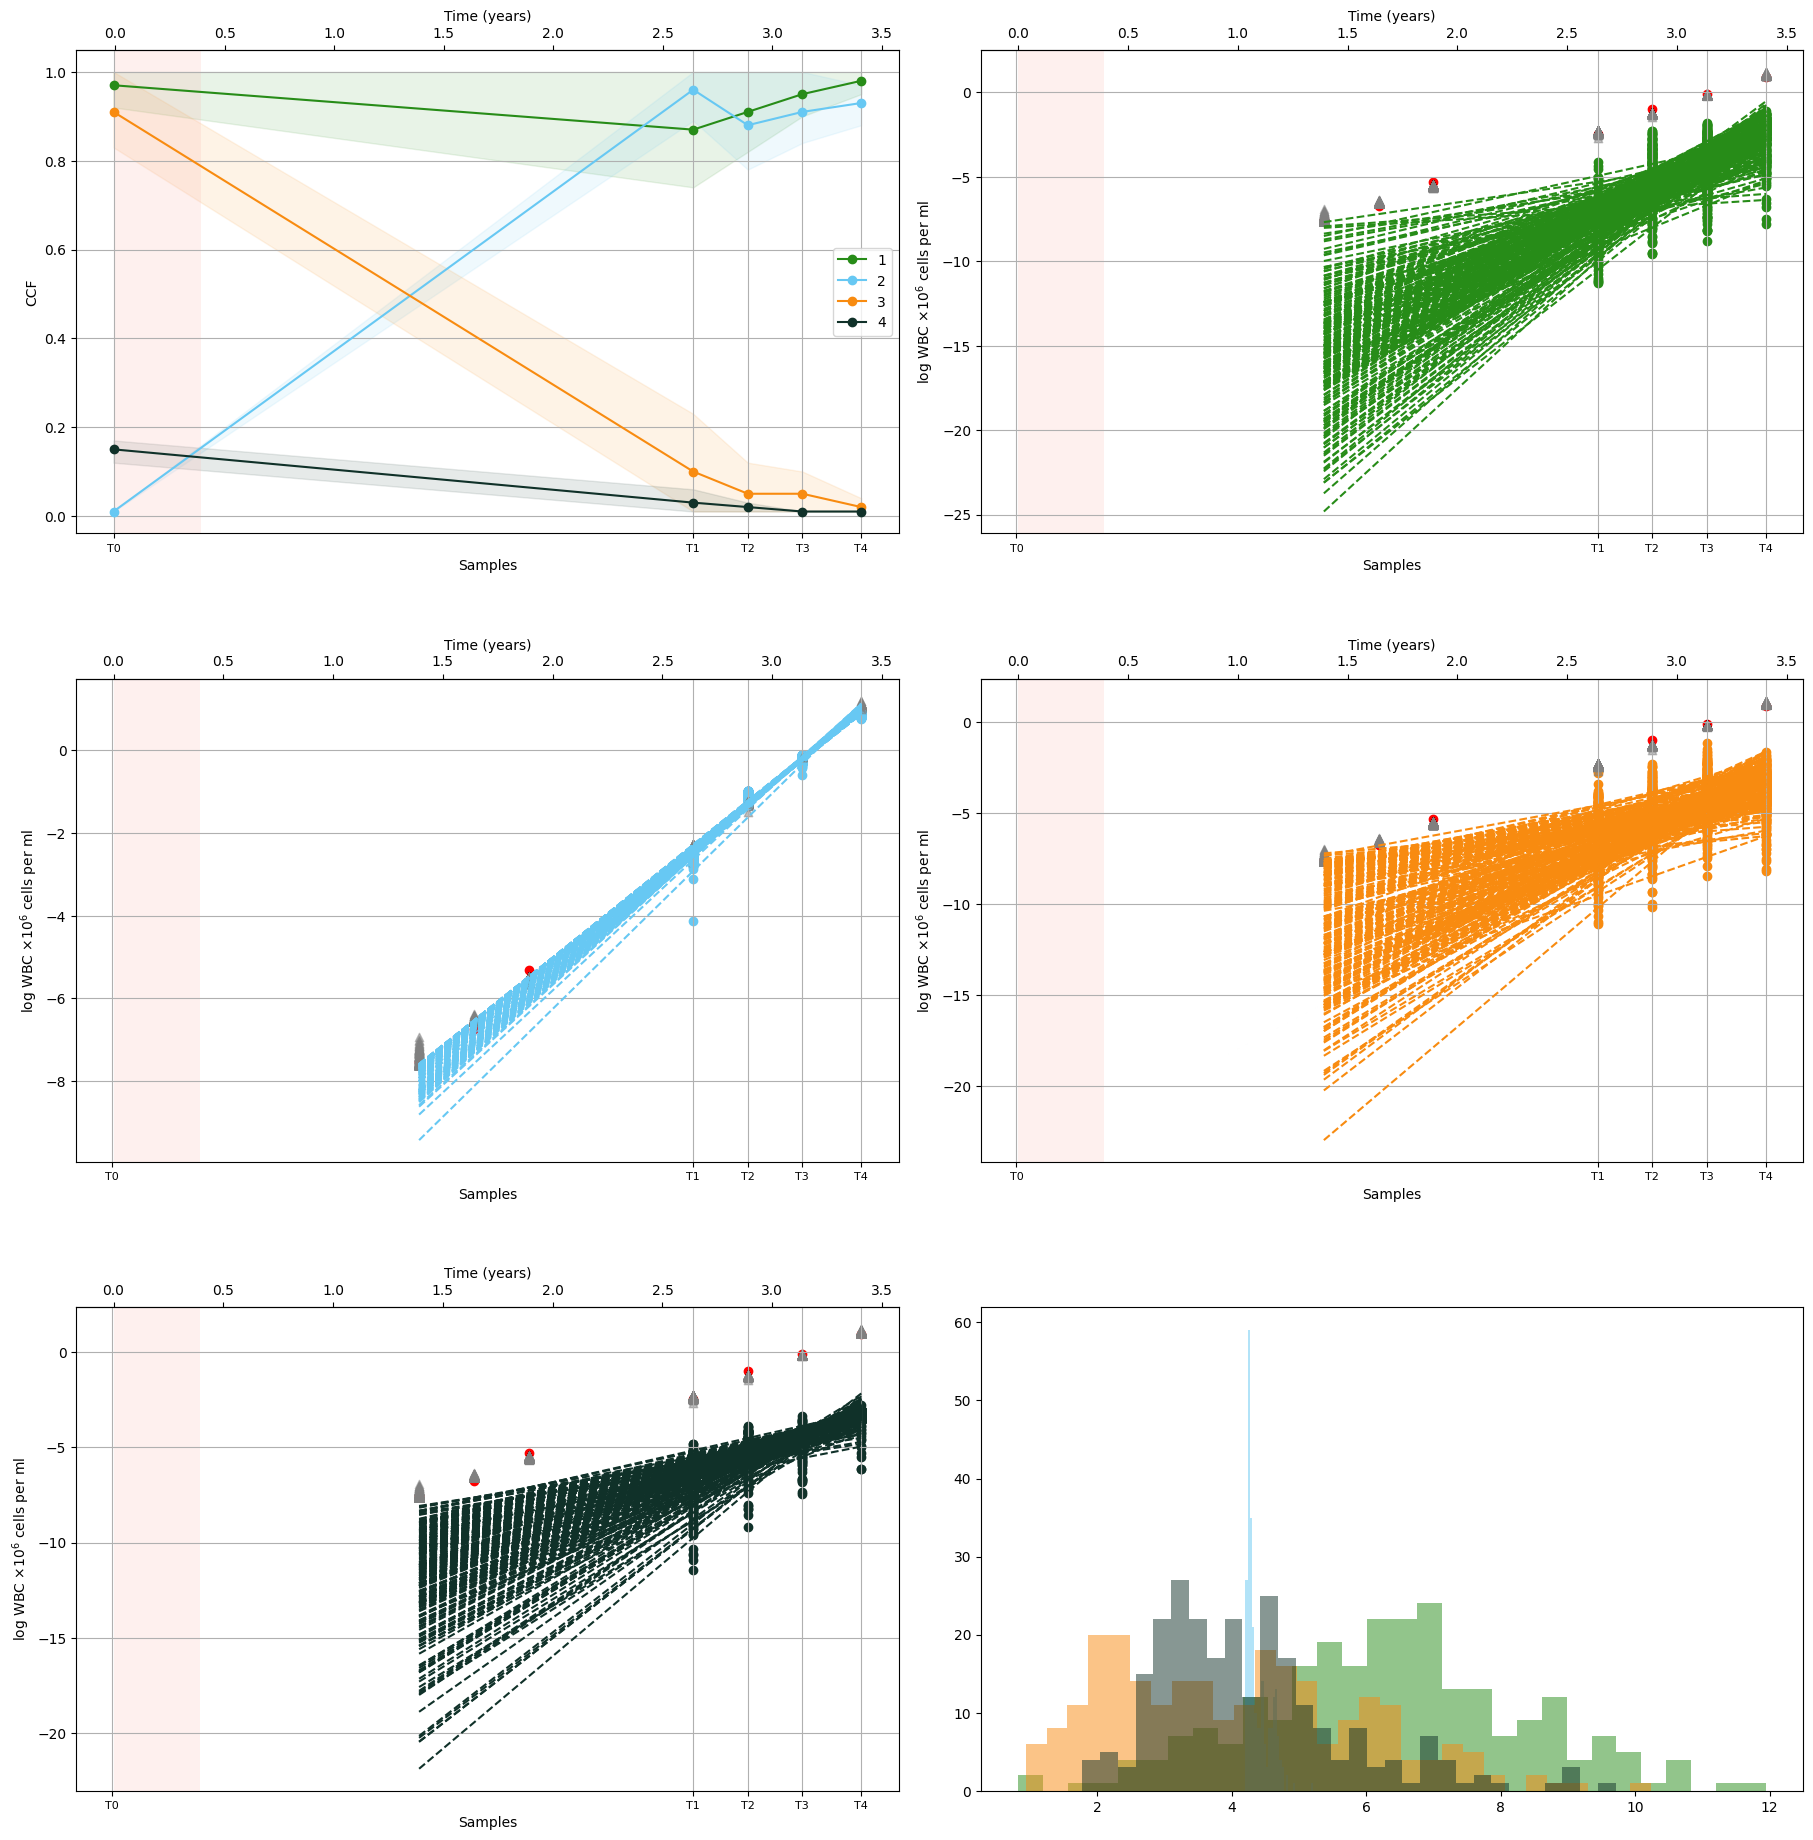

In [69]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    

    

    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
#     slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        
        # plot subclones
        x_year = [ i/365 for i in np.array(times_sample)][1:]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)
        
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(CLL_guess)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)


        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  
#         slopes_mcmc[cluster].append(model[0])

        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax3, 2, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax4, 3, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax5, 4, n_clusters = 4, index_samples_model = slice(1,5), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


slopes_mcmc_transposed = {col: np.array([slopes_mcmc[row][col] for row in slopes_mcmc]) for col in range(len(slopes_mcmc[0]))}    
for cluster in range(n_clusters):
    ax6.hist(slopes_mcmc_transposed[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster+1), bins = 30)



In [71]:
clusters = [1,2,3,4]
for cluster in clusters:
    mean = np.mean(slopes_mcmc_transposed[cluster-1], axis=0)
    lower_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")

Cluster: 1, mean:6.3379, 95% Confidence Interval: 2.5305 to 10.0964
Cluster: 2, mean:4.3895, 95% Confidence Interval: 4.2239 to 4.7423
Cluster: 3, mean:4.0921, 95% Confidence Interval: 1.4306 to 7.8386
Cluster: 4, mean:4.2735, 95% Confidence Interval: 2.1151 to 7.6792
